In [196]:
import pandas as pd
import numpy as np
from scipy import stats
import sys
import matplotlib.pyplot as plt
from dateutil.parser import parse
import parse as str_parse
from intersection_proximity import intersection_proximity
from importlib import reload
from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
import seaborn as sns

users = pd.read_csv('ml-users.csv') 
%matplotlib notebook

In [5]:
crop_rows = -1

In [7]:
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip')

if crop_rows > 0:
    df_interactions = df_interactions.head(crop_rows)

isna_result = pd.isna(df_interactions['action'])
df_interactions= df_interactions[~isna_result]
isna_result = pd.isna(df_interactions['action'])
assert sum(df_interactions['action'].isna()) == 0

df_interactions.rename(columns = {'ml-interactions.csv':'timestamp'}, inplace = True)

In [99]:
label_correctness = pd.read_csv('ml-label-correctness.csv')

In [100]:
labeling_cols = ['user_id', 'audit_task_id', 'temporary_label_id']

In [101]:
label_correctness.set_index(labeling_cols, inplace=True)

In [102]:
# TODO: figure out why there are duplicates
label_correctness = label_correctness[~label_correctness.index.duplicated()]

In [103]:
label_correctness = label_correctness[~label_correctness['correct'].isna()]

In [104]:
df_interactions.set_index(labeling_cols, inplace=True)

In [105]:
df_interactions.reset_index(inplace=True)

In [29]:
# # fill nan temporary label id's
# df_interactions['temporary_label_id'] = df_interactions['temporary_label_id'].fillna(method='bfill')

# # get rid of nan label id's
# df_interactions = df_interactions[~pd.isna(df_interactions['temporary_label_id'])]

In [106]:
labels = df_interactions[df_interactions['action'] == 'LabelingCanvas_FinishLabeling']

In [107]:
labels.reset_index( inplace=True)

In [108]:
labels['audit_task_id'] = labels['audit_task_id'].astype(int)

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [109]:
labels['temporary_label_id'] = labels['temporary_label_id'].astype(int)

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [110]:
labels.set_index(labeling_cols, inplace=True)

In [111]:
labels_joined = label_correctness.join(labels, how='inner')

In [112]:
labels_joined.drop(['action', 'audit_task_interaction_id', 'timestamp', 'mission_id'], axis=1, inplace=True)

In [113]:
def parse_note(x):
    result = str_parse.parse('labelType:{},canvasX:{},canvasY:{}', x)
    return pd.Series({
        'labelType': result[0],
        'canvasX': result[1],
        'canvasY': result[2]
    })
    
labels_joined = labels_joined.join(labels_joined['note'].apply(parse_note))

In [114]:
labels_joined.drop('note', inplace=True, axis=1)

In [115]:
labels_joined['correct'] = labels_joined['correct'] == 't'

In [116]:
labels_joined

label_id  \
user_id                              audit_task_id temporary_label_id             
0e1ae564-6d72-4670-98e4-71369cc5ab26 3366          5                      10407   
                                     3367          7                      10409   
                                     3368          3                      10412   
                                                   4                      10413   
                                     3378          20                     10429   
                                     3639          3                      11765   
                                     3641          5                      11769   
                                                   6                      11771   
                                                   8                      11775   
                                                   9                      11776   
                                     3643          12                     11781   
                                     3646          19                     11794   
                                     3654          32                     11820   
                                                   33                     11821   
                                                   34                     11822   
                                                   38                     11827   
                                     3658          41                     11836   
                                                   42                     11837   
                                                   43                     11838   
                                                   45                     11844   
                                                   46                     11845   
                                     3661          48                     11848   
                                                   49                     11852   
                                                   51                     11854   
                                     3663          59                     11870   
                                     3665          63                     11875   
                                                   65                     11878   
                                     3666          68                     11883   
                                                   69                     11884   
                                                   70                     11885   
...                                                                         ...   
fa0bbee4-b98d-4eb3-b6da-d9e9aa287f6c 33            83                       343   
                                                   84                       344   
                                                   85                       345   
                                                   87                       347   
                                                   88                       348   
                                                   89                       349   
                                                   90                       350   
                                     34            91                       351   
                                                   92                       352   
                                                   93                       353   
                                                   94                       354   
                                                   95                       355   
                                                   96                       356   
                                                   97                       357   
                                     36            98                       358   
                                                   99                       359   
    

In [117]:
curb_ramp = labels_joined[labels_joined['labelType'] == 'CurbRamp']

In [118]:
X = curb_ramp[['canvasX', 'canvasY', 'pitch']].values

In [131]:
y = curb_ramp['correct'].values

In [143]:
X = X.astype(int)

<IPython.core.display.Javascript object>


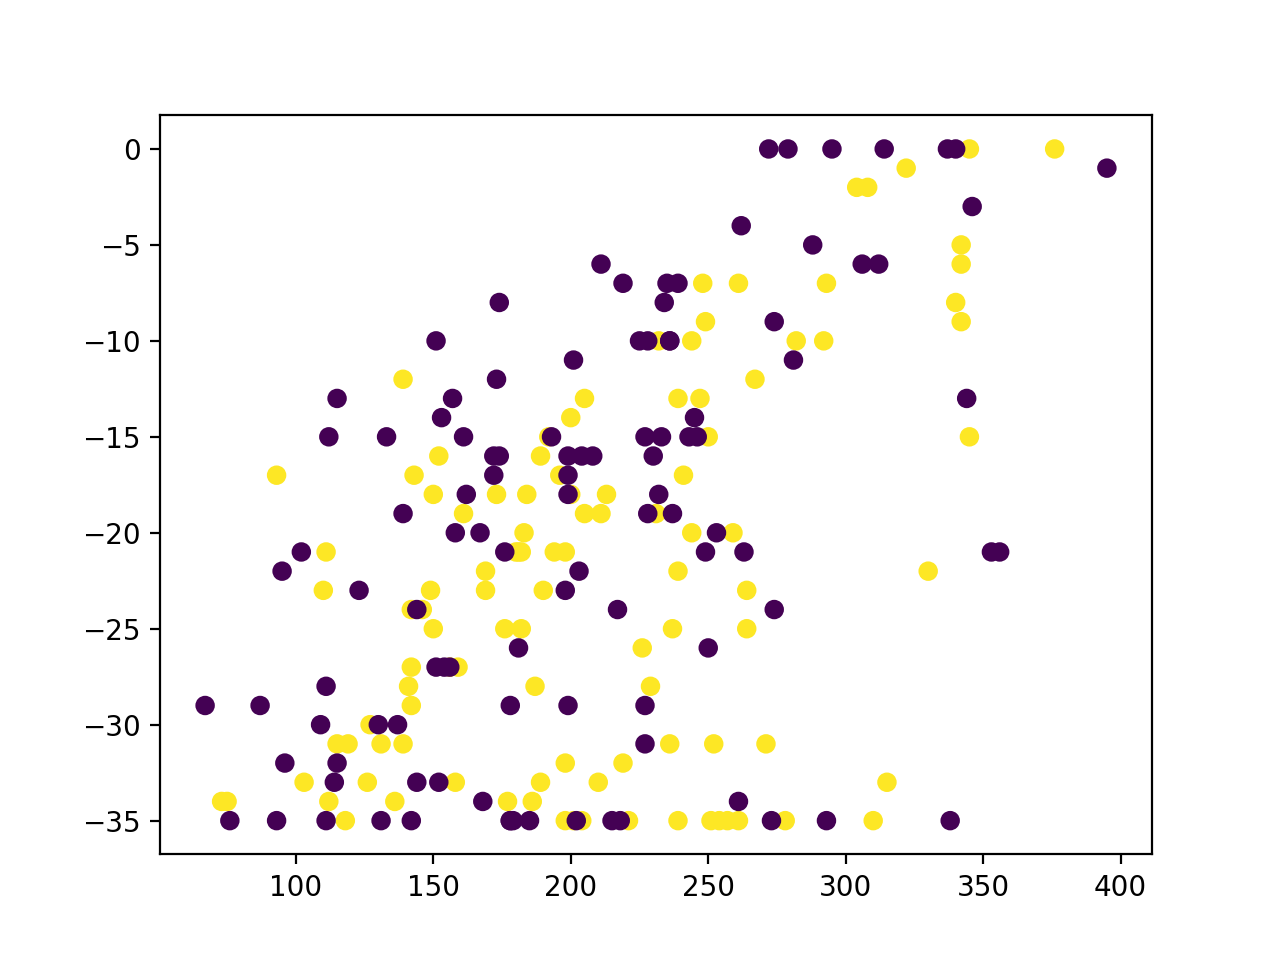

In [158]:
plt.figure()
plt.scatter(X[:, 1], X[:, 2], c=y)

In [199]:
clf = SGDRegressor()

In [200]:
clf.fit(X, y)

/Users/neil/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [201]:
y_pred = clf.predict(X)

<IPython.core.display.Javascript object>


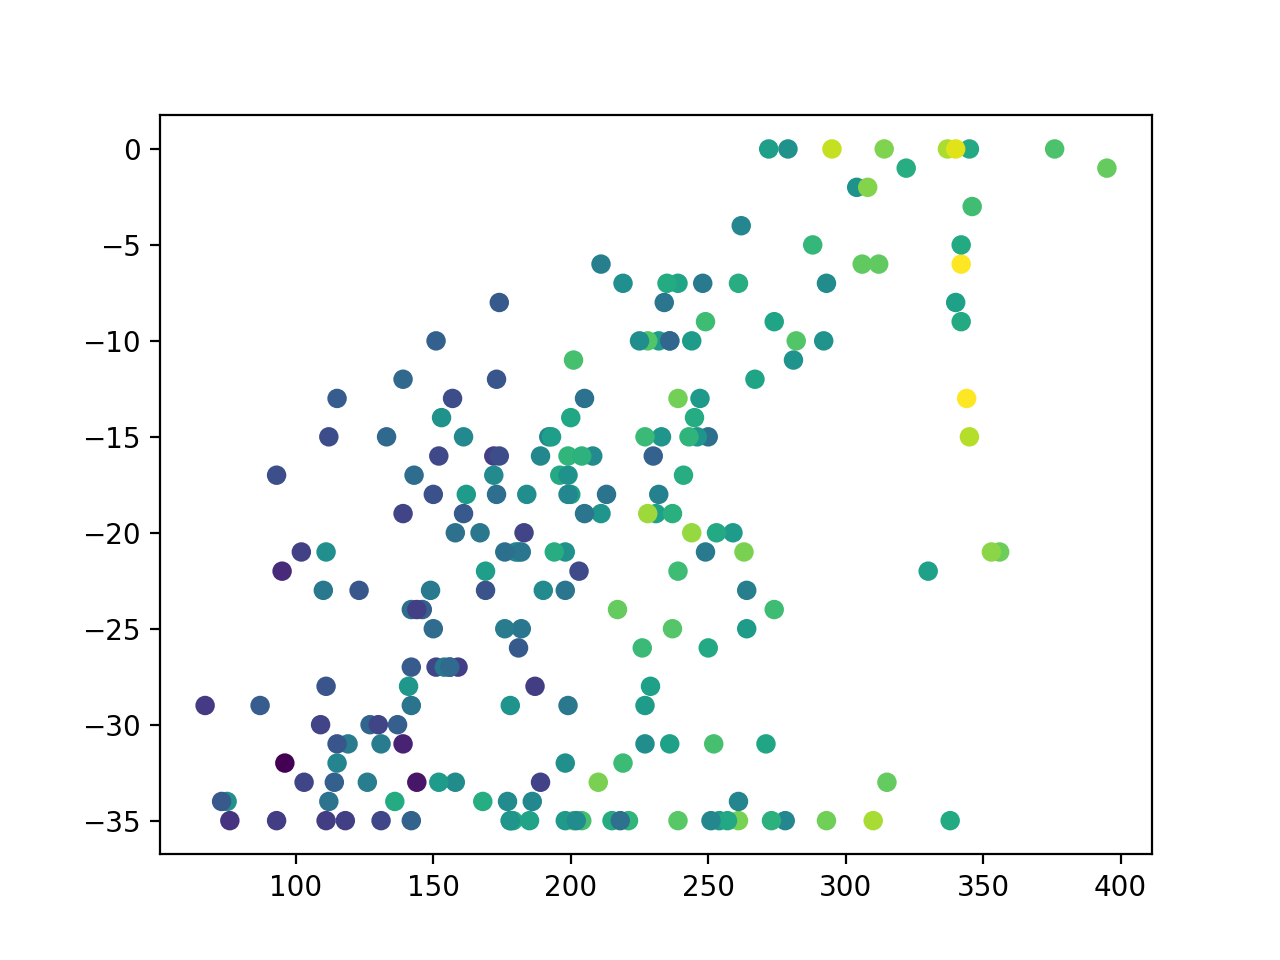

In [203]:
plt.figure()
plt.scatter(X[:, 1], X[:, 2], c=y_pred)

<IPython.core.display.Javascript object>


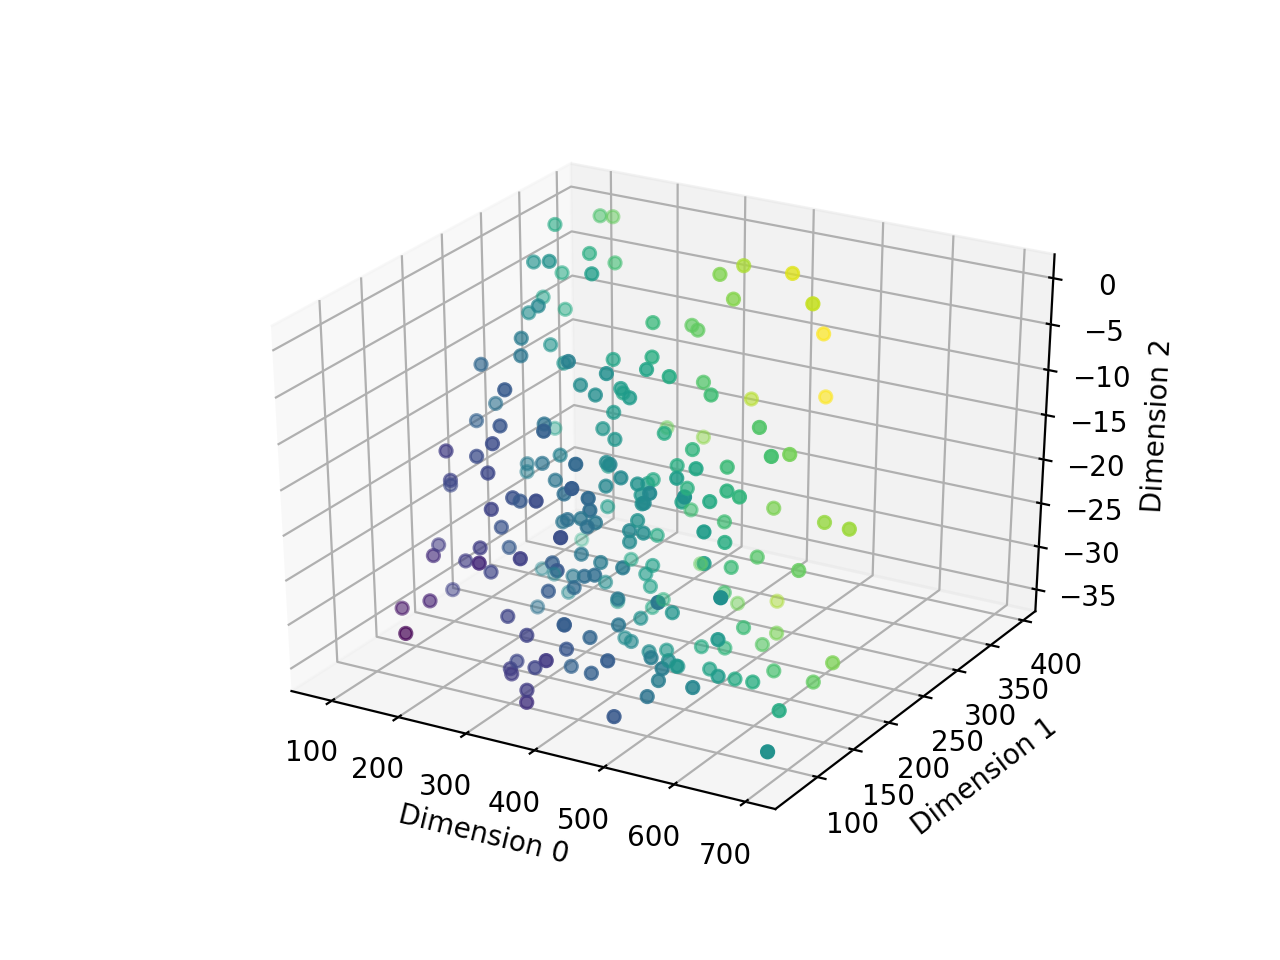

In [207]:
fig, ax = plt.subplots()
ax = plt.axes(projection='3d')

xline = X[:, 0]
yline = X[:, 1]
zline = X[:, 2]

ax.set_xlabel('Dimension 0')
ax.set_ylabel('Dimension 1')
ax.set_zlabel('Dimension 2')
ax.scatter3D(xline, yline, zline, c=y_pred)

In [218]:
def dist_prox(row):
    try:
        ip = intersection_proximity.compute_proximity(row.lat, row.lng)
        return pd.Series({
            'distance': ip[0],
            'percent': ip[1]
        })
    except Exception:
        return pd.Series({
            'distance': -1,
            'percent': -1
        })

In [358]:
le = preprocessing.LabelEncoder()
# transform label_type into an int
labels_joined['label_id'] = le.fit_transform(labels_joined['labelType'])

In [359]:
# labels_joined = labels_joined.join(labels_joined.apply(dist_prox, axis=1))

In [377]:
X = labels_joined[['pitch', 'label_id', 'canvasX', 'canvasY', 'distance', 'percent']].values
y = labels_joined['correct'].astype(int).values

In [378]:
# Undersample the majority class
incorrect_indices, = np.where(y == 0)
correct_indices, = np.where(y == 1)
needed = min(len(incorrect_indices), len(correct_indices))
chosen_indices = np.concatenate((np.random.choice(correct_indices, needed, replace=False), np.random.choice(incorrect_indices, needed, replace=False)))

X = X[chosen_indices]
y = y[chosen_indices]

In [379]:
from sklearn.ensemble import RandomForestClassifier

In [362]:
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

In [391]:
cutoff_invalid = 0.8
cutoff_valid = 0.8

In [392]:
total = 0
predicted = 0
tp = 0
tn = 0
fp = 0
fn = 0
counter = 0
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(X):
    counter += 1

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
#     clf = svm.SVC(gamma='scale')
    clf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=10000)
    clf.fit(X_train, y_train)
    prediction = clf.predict_proba(X_test)
    pred_neg = prediction[:, 0] > cutoff_invalid
    pred_pos = prediction[:, 1] > cutoff_valid
    
    tn_ = np.sum(y_test[pred_neg] == 0)
    fn_ = np.sum(pred_neg) - tn_
    tp_ = np.sum(y_test[pred_pos] == 1)
    fp_ = np.sum(pred_pos) - tp_
    
    print(f'{tn_}, {fn_}, {tp_}, {fp_}')
    
    predicted += (tn_ + fn_ + tp_ + fp_)
    tn += tn_
    fn += fn_
    tp += tp_
    fp += fp_
    
    total += y_test.shape[0]
    
    print(counter, end="\r", flush=True)

18, 6, 22, 10
32, 5, 26, 12
26, 3, 22, 7
31, 6, 21, 7
26, 7, 25, 5


In [393]:
accuracy = (tp + tn) / predicted

In [395]:
print(f'precision:\t{100*accuracy:.2f}%')
print(f'recall:\t\t{100*predicted/total:.2f}%')
print(f'tp / tp + fn:\t{100*tp/(tp+fp):.2f}%')
print(f'tn / tn + fp:\t{100*tn/(tn+fn):.2f}%')

precision:	78.55%
recall:		17.34%
tp / tp + fn:	73.89%
tn / tn + fp:	83.12%


In [374]:
np.sum(labels_joined['correct']) / labels_joined.shape[0]

0.8310536044362292